In [1]:
"""
LOAD TEST WEB SERVER

CREATED: 13-APR-2022
LAST EDIT: 3-AUG-2022
AUTHORS: DUANE RINEHART

"""
import os
import time
import pandas as pd
import psutil


win_data_dir = "E:/dev/web_server_load_test/"
linux_data_dir = "."
prep_id = "DK59"

def load_app_constants():
    """
    LOAD APP/ENVIRONMENT SETTINGS (ESP. CROSS-PLATFORM)
    """
    if os.name == "nt":
        input_fullPath = os.path.join(win_data_dir)
    else:
        input_fullPath = os.path.join(linux_data_dir)
    return input_fullPath


def sizeof_fmt(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"


def capture_dir_listing(data_root):
    """
    PRIOR LIST OF REPRESENTATIVE DIRECTORY CONTENTS GENERATED WITH:
    [ON pons.dk.ucsd.edu]
    cd /data/neuroglancer/DK55/neuroglancer_data/C1
    PREP_ID='DK73' && DIR='325_325_20000' && ls -l $DIR | awk 'BEGIN {OFS="\t"} { print $9, $5 }' > ~/"$PREP_ID-$DIR.tsv"   

    """

    input_filename = f"{prep_id}-325_325_20000.tsv"
    input_fullPath = os.path.join(data_root, input_filename)

    start = time.time()
    dfFileList = pd.read_csv(
        input_fullPath, sep="\t", names=["fname", "size_(bytes)"], header=None
    )
    dfFileList.index.name = "id"
    end = time.time()
    print(f"PREP ID: {prep_id}")
    print(f"Read tsv: {input_fullPath}")
    print("Operation time: ", (end - start), "sec")
    return dfFileList


data_root = load_app_constants()
files_size_array = capture_dir_listing(data_root)


PREP ID: DK59
Read tsv: ./DK59-325_325_20000.tsv
Operation time:  0.2524991035461426 sec


In [2]:
print(f"PREP ID: {prep_id}")
print('n = ', len(files_size_array.index))
print('μ =', sizeof_fmt(files_size_array['size_(bytes)'].mean()))
print('median = ', sizeof_fmt(files_size_array['size_(bytes)'].median()))
print('mode = ', sizeof_fmt(files_size_array['size_(bytes)'].mode().iat[0]))
print('min = ', sizeof_fmt(files_size_array['size_(bytes)'].min()))
print('max = ', sizeof_fmt(files_size_array['size_(bytes)'].max()))
print('σ = ', files_size_array['size_(bytes)'].std())
mode = files_size_array['size_(bytes)'].mode().iat[0]
print("+++")
print("ONLY FILES > ORG. MODE:")
df_filter = files_size_array['size_(bytes)'] > mode + files_size_array['size_(bytes)'].std()
filtered_df_files_size_array = files_size_array[df_filter]

files_size_array['size_(bytes)'].mean()


print('filtered n = ', len(filtered_df_files_size_array.index))
print('(filtered μ) x̄ = ', sizeof_fmt(filtered_df_files_size_array['size_(bytes)'].mean()))
print('filtered median = ', sizeof_fmt(filtered_df_files_size_array['size_(bytes)'].median()))
print('filtered mode = ', sizeof_fmt(filtered_df_files_size_array['size_(bytes)'].mode().iat[0]))
print('filtered min = ', sizeof_fmt(filtered_df_files_size_array['size_(bytes)'].min()))
print('filtered max = ', sizeof_fmt(filtered_df_files_size_array['size_(bytes)'].max()))
print('σ = ', filtered_df_files_size_array['size_(bytes)'].std())

PREP ID: DK59
n =  211073
μ = 2.0MiB
median =  8.3KiB
mode =  8.3KiB
min =  887.0B
max =  8.0MiB
σ =  3414032.0281258775
+++
ONLY FILES > ORG. MODE:
filtered n =  56713
(filtered μ) x̄ =  7.3MiB
filtered median =  7.8MiB
filtered mode =  7.8MiB
filtered min =  3.3MiB
filtered max =  8.0MiB
σ =  1154634.691091191


ORG - DK59


<AxesSubplot:>

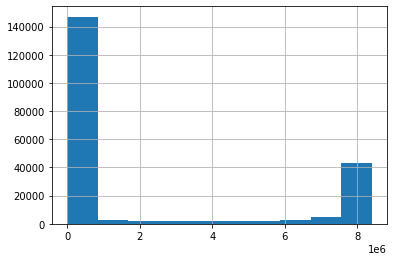

In [3]:
print(f"ORG - {prep_id}")
files_size_array['size_(bytes)'].hist()

REVISED - DK59


<AxesSubplot:>

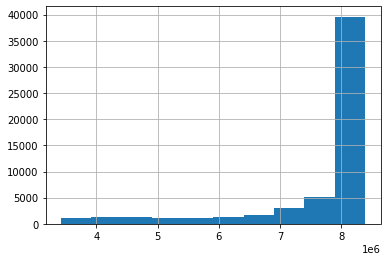

In [4]:
print(f"REVISED - {prep_id}")
filtered_df_files_size_array['size_(bytes)'].hist()

In [6]:
#REPRESENTATIVE IMAGES DURING SESSION SUM IS BASED ON HISTORICAL DAILY AVERAGE (https://activebrainatlas.ucsd.edu/awstats/awstats.pl)
#MAR, 2022 AVG 8.82GB
aggregate_threshold = (8.82e+9) # IN BYTES
aggregate_file_size = 0
#out_filename = f'{prep_id}-load_test_target_transfer_list.xlsx'
out_filename = f'{prep_id}-load_test_target_transfer_list.tsv.gz'
filtered_df_files_size_array['selected'] = ' ' # ADD TO EXISTING DATAFRAME

for i in filtered_df_files_size_array.sample(frac=1).iterrows(): #ref: https://stackoverflow.com/questions/43509114/randomly-sample-rows-of-a-dataframe-until-the-desired-sum-of-a-column-is-reached
    if (aggregate_file_size + i[1]['size_(bytes)']) <= aggregate_threshold:
        aggregate_file_size += i[1]['size_(bytes)']
        filtered_df_files_size_array.at[i[0], 'selected'] = 1

# SAVE RESULTS TO FILE ('size_(bytes)' COLUMN SUM SHOULD EQUAL aggregate_threshold)
data_root = load_app_constants()
output_fullPath = os.path.join(data_root, out_filename)
filtered_df_files_size_array.index.name = 'id'
filtered_df_files_size_array['transfer_time (s)'] = 0 #NEW COLUMN NAME; DEFAULT VALUE = 0
#filtered_df_files_size_array[filtered_df_files_size_array['selected']==1].to_excel(output_fullPath, columns=['fname','size_(bytes)', 'transfer_time (s)'])
#filtered_df_files_size_array.to_excel(out_filename)
filtered_df_files_size_array[filtered_df_files_size_array['selected']==1].to_csv(output_fullPath, sep="\t", columns=['fname','size_(bytes)', 'transfer_time (s)'], compression="gzip")
filtered_df_files_size_array.to_csv(out_filename, sep="\t", compression="gzip")

/tmp/ipykernel_489632/4292400048.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_files_size_array['selected'] = ' ' # ADD TO EXISTING DATAFRAME
/tmp/ipykernel_489632/4292400048.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_files_size_array['transfer_time (s)'] = 0 #NEW COLUMN NAME; DEFAULT VALUE = 0


In [13]:
import pandas as pd
import wget
from timeit import default_timer as timer
import glob
import sqlite3

#in_filename = f'{prep_id}-load_test_target_transfer_list.xlsx'
in_filename = f'{prep_id}-load_test_target_transfer_list.tsv.gz'
#out_filename = f'{prep_id}-load_test_results.xlsx'
out_filename = f'{prep_id}-load_test_results.tsv.gz'
db_file = f"results-{prep_id}.db"
base_url = f'https://activebrainatlas.ucsd.edu/data/{prep_id}/neuroglancer_data/C1/325_325_20000/'

def speed_test(url):
    local_file = 'tmp.del'
    start_time = timer()
    wget.download(url, local_file)
    end_time = timer()
    elapsed_time = round(end_time - start_time, 2)

    #CLEANUP
    fileList = glob.glob('*.del')
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    return elapsed_time


def store_results():
    conn = sqlite3.connect(db_file)

# try:
#     conn = sqlite3.connect(db_file)
#     qry = f"SELECT * FROM results, (SELECT COUNT(*) AS OUTSTANDING FROM results WHERE 'transfer_time (s)' = 0), (SELECT COUNT(*) AS TOTAL FROM results) "
#     selected_files = pd.read_sql_query(qry, conn)
#     print("DATA PULLED FROM DATABASE")
# except:    
filtered_df_files_size_array = pd.read_csv(in_filename, sep="\t", compression="gzip")
selected_files = filtered_df_files_size_array.loc[filtered_df_files_size_array['selected'] == 1]
print("DATA PULLED FROM FILE")
# conn = sqlite3.connect(db_file)
# selected_files.to_sql('results', conn)
# print("DATA ADDED TO DB")
    
total_files = selected_files.shape[0]
print(f"TOTAL RECORDS: {total_files}")

# macro_start_time = timer()
# for index, row in selected_files.iterrows():
#     # if row % 10:#save every 10
#     #     filtered_df_files_size_array.to_excel(out_filename)
        
#     filename = row['fname']
#     url = base_url + filename
#     elapsed_time = speed_test(url)
#     print(index, url)
#     print(f"TRANSFER TIME: {elapsed_time}s")
#     print(f"PCT_COMPLETE: {round(index/total_files,1)}%")

#     #UPDATE DATAFRAME WITH NEW TRANSFER DATE
#     filtered_df_files_size_array.loc[filtered_df_files_size_array['fname'] == filename, 'transfer_time'] = elapsed_time

# macro_end_time = timer()
# macro_elapsed_time = round(macro_end_time - macro_start_time, 2)
# filtered_df_files_size_array.to_excel(out_filename)
# print(f"MACRO ELAPSED TIME: {macro_elapsed_time}")

DATA PULLED FROM FILE
TOTAL RECORDS: 0


In [35]:
#filtered_df_files_size_array
#[filtered_df_files_size_array['selected']=="1"]
filtered_df_files_size_array.loc[filtered_df_files_size_array['selected']=="1"]

#filtered_df_files_size_array.loc[filtered_df_files_size_array['selected'] == 1]
#selected_files = filtered_df_files_size_array.loc[filtered_df_files_size_array['selected'] == 1]
#selected_files

,id,fname,size_(bytes),selected,transfer_time (s)
3,65157,10240-10496_10240-10496_248-249.gz,72604.0,1,0
9,66092,10240-10496_10496-10752_217-218.gz,49973.0,1,0
92,68005,10240-10496_11520-11776_192-193.gz,56128.0,1,0
107,68040,10240-10496_11520-11776_224-225.gz,97940.0,1,0
171,68570,10240-10496_11776-12032_264-265.gz,53433.0,1,0
...,...,...,...,...,...
3536696,15118112,9984-10240_21248-21504_257-258.gz,89961.0,1,0
3536743,15118512,9984-10240_21504-21760_181-182.gz,68589.0,1,0
3536746,15118517,9984-10240_21504-21760_185-186.gz,71534.0,1,0
3536781,15118582,9984-10240_21504-21760_243-244.gz,76642.0,1,0


In [40]:
import pandas as pd
import sqlite3
prep_id = "DK39"
in_filename = f'{prep_id}-load_test_target_transfer_list.xlsx'
db_file = f"results-{prep_id}.db"

try:
    conn = sqlite3.connect(db_file)
    qry = f"SELECT * FROM results, (SELECT COUNT(*) AS OUTSTANDING FROM results WHERE 'transfer_time (s)' = 0), (SELECT COUNT(*) AS TOTAL FROM results) "
    selected_files = pd.read_sql_query(qry, conn)
    print("DATA PULLED FROM DATABASE")
except:    
    filtered_df_files_size_array = pd.read_excel(in_filename, engine='openpyxl')
    selected_files = filtered_df_files_size_array.loc[filtered_df_files_size_array['selected'] == 1]
    selected_files = selected_files.astype({'transfer_time (s)': float}, errors='raise') 
    print("DATA PULLED FROM FILE")
    conn = sqlite3.connect(db_file)
    selected_files.to_sql('results', conn)
    print("DATA ADDED TO DB")
    
total_files = selected_files.shape[0]
print(f"TOTAL RECORDS: {total_files}")


def save_data(conn, values):
    sql = f'''UPDATE results SET 'transfer_time (s)' = {values[1]} WHERE id = {values[0]} '''
    print(sql)
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()
    return cur.lastrowid


total_files = selected_files.shape[0]
print(total_files)

# macro_start_time = timer()
# for index, row in selected_files.iterrows():
#     # if row % 10:#save every 10
#     #     filtered_df_files_size_array.to_excel(out_filename)
#     idx = row['index']    
#     filename = row['fname']
#     url = base_url + filename
#     elapsed_time = speed_test(url)
#     print(index, url)
#     print(f"TRANSFER TIME: {elapsed_time}s")
#     print(f"PCT_COMPLETE: {round(index/total_files,1)}%")

#     #UPDATE DATAFRAME WITH NEW TRANSFER DATE
#     filtered_df_files_size_array.loc[filtered_df_files_size_array['fname'] == filename, 'transfer_time'] = elapsed_time
#     values = (idx, elapsed_time)
#     out = save_data(conn, values)
#     print(out)


DATA PULLED FROM FILE
DATA ADDED TO DB
TOTAL RECORDS: 36811
36811


/usr/local/share/pipeline/lib/python3.8/site-packages/pandas/core/generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [39]:
selected_files = selected_files.astype({'transfer_time (s)': float}, errors='raise') 
selected_files

,id,fname,size_(bytes),selected,transfer_time (s)
0,2188,10112-10240_11136-11264_256-320.gz,122631,1,0.0
6,2212,10112-10240_11520-11648_256-320.gz,206990,1,0.0
9,2235,10112-10240_11776-11904_192-256.gz,162241,1,0.0
12,2244,10112-10240_11904-12032_256-320.gz,213719,1,0.0
15,2258,10112-10240_12160-12288_128-192.gz,144103,1,0.0
...,...,...,...,...,...
190528,915834,9984-10112_18432-18560_128-192.gz,315741,1,0.0
190530,915836,9984-10112_18432-18560_256-320.gz,225511,1,0.0
190544,915875,9984-10112_19072-19200_192-256.gz,152032,1,0.0
190548,915898,9984-10112_19328-19456_128-192.gz,242618,1,0.0
